<a href="https://colab.research.google.com/github/Strojove-uceni/final-projects-i_am_not_a_robot/blob/main/captcha_basic_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install libraries

In [1]:
# install and load packages
! pip install patool
! pip install pyunpack

import argparse
import os
import random
import requests
import zipfile
import errno
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pyunpack import Archive
import glob
import string
from PIL import Image
from tqdm import tqdm
import torch.nn.functional 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

     |████████████████████████████████| 77 kB 3.7 MB/s 


# Connect and download data from Disk

In [2]:
# connect to google drive for saving models
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# new
# download files from google drive

# load train data
!gdown --id 1zt8NIVLGSxoGrlGd-BoGehK9DLwEMPTD

# load test data
!gdown --id 18qEmkB012SLsWLrvxcAnhH_uiuhBZ9C4


Downloading...
From: https://drive.google.com/uc?id=1zt8NIVLGSxoGrlGd-BoGehK9DLwEMPTD
To: /content/captcha_train.tar.gz
100% 1.25G/1.25G [00:06<00:00, 197MB/s]
Downloading...
From: https://drive.google.com/uc?id=18qEmkB012SLsWLrvxcAnhH_uiuhBZ9C4
To: /content/captcha_test.tar.gz
100% 252M/252M [00:05<00:00, 48.5MB/s]


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_cudas = torch.cuda.device_count()

print(f'We are now using {device}. There are {n_cudas} available gpus.')

if torch.cuda.is_available():
    print(f'{torch.cuda.get_device_name(0)}')

We are now using cuda. There are 1 available gpus.
Tesla K80


In [5]:
# create folders to unzip data
! mkdir 'train'
! mkdir 'test'

# unzip data
Archive('captcha_train.tar.gz').extractall('train')
Archive('captcha_test.tar.gz').extractall('test')

In [6]:
# check number of files
train_labels = os.listdir('train/train')
print('train files:', len(train_labels))

test_labels = os.listdir('test/test')
print('test files:', len(test_labels))

train files: 198511
test files: 40000


# Check the dataset

In [7]:
captcha_len = 4

In [8]:
# check distribution of symbols in train set

# these are all symbols the captchas will have
symbols = string.ascii_uppercase + string.ascii_lowercase + string.digits  

symbols_help = string.ascii_lowercase + string.digits 
index = {}
for cha in symbols_help:
  index[cha] = 0


In [9]:
for item in train_labels:
  get_label = str(item).split('.')[0]
  for cha in get_label:
    index[cha] += 1

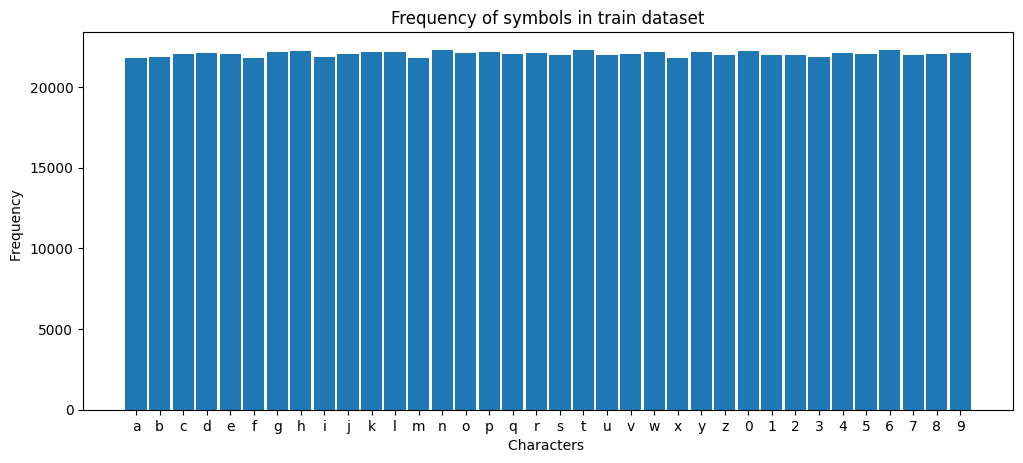

In [10]:
plt.figure(num=None, figsize=(12, 5), dpi=100, facecolor='w', edgecolor='k')
plt.bar(index.keys(), index.values(), width=0.9)
plt.title('Frequency of symbols in train dataset')
plt.xlabel("Characters ", fontsize=10)  
plt.ylabel("Frequency  ", fontsize=10)
plt.show()

# Setup for model

In [11]:
workers = 2                           # worker threads for loading the data with the DataLoader
batch_size = 256                      # size of batch
image_size = [60, 180]                # size of imput images
nc = 3                                # number of color channels in the input images

# normalization parameters
normalize_mean = (0.485, 0.456, 0.406)
normalize_std = (0.229, 0.224, 0.225)

# for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [12]:
class Custom_Dataset(torch.utils.data.Dataset):
    
    def __init__(self, data_dir, data_labels):
        self.data_dir = data_dir
        self.data_labels = data_labels
        
    def __len__(self):
        return len(self.data_labels)
    
    def __getitem__(self, index):
        image_label = self.data_labels[index]
        image_fp = os.path.join(self.data_dir, image_label)
        image = Image.open(image_fp).convert('RGB')
        image = self.transform(image)
        text = image_label.split(".")[0]
        return image, text
    
    def transform(self, image):
        
        transform_ops = transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(normalize_mean, normalize_std),
        ])
        return transform_ops(image)

In [13]:
# create dataloaders

dataset_train = Custom_Dataset('train/train', train_labels) 
dataset_test = Custom_Dataset('test/test', test_labels)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, num_workers=workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, num_workers=workers, shuffle=False)

print(len(train_loader), len(test_loader))

776 157


In [14]:
# check dimensions
print(len(train_labels)/batch_size, len(test_labels)/batch_size)
# decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

775.43359375 156.25


In [15]:
def UnNormalizeBatch(batch):
    for i in range(batch.shape[3]):
       batch[:,:,:,i] = (batch[:,:,:,i] * normalize_std[i]) + normalize_mean[i]

    return batch

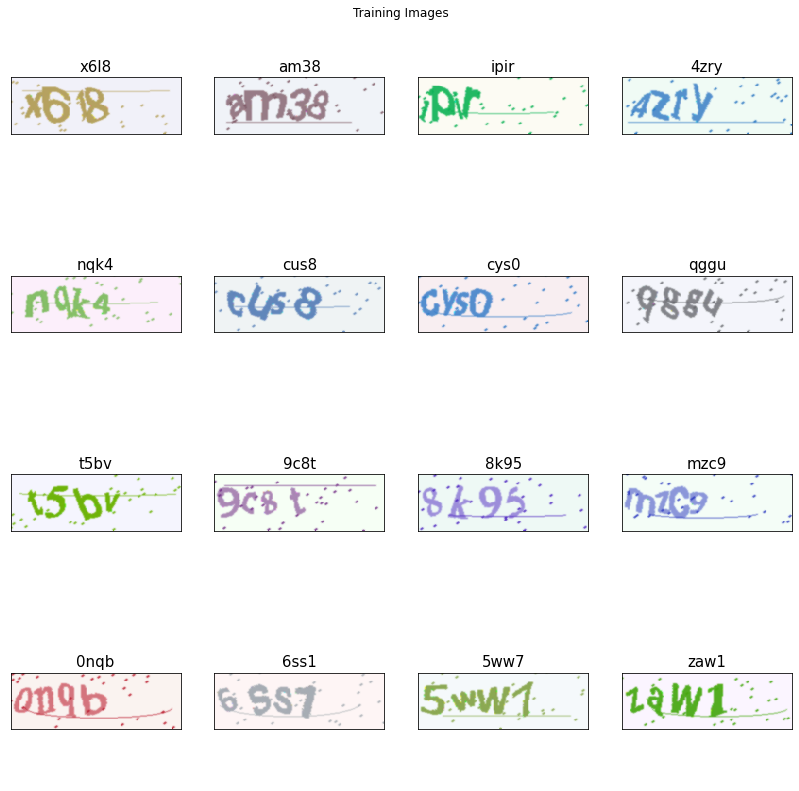

In [16]:
# view some train images
real_batch = next(iter(train_loader))
real_batch_pictures = np.transpose(real_batch[0].to(device).cpu().detach().numpy(),(0,2,3,1))
real_batch_pictures = UnNormalizeBatch(real_batch_pictures)

fig = plt.figure(figsize=(14,14))
plt.axis("off")
plt.title("Training Images")

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(real_batch_pictures[i], interpolation='nearest')
    plt.title(real_batch[1][i], color='k', fontsize=15)

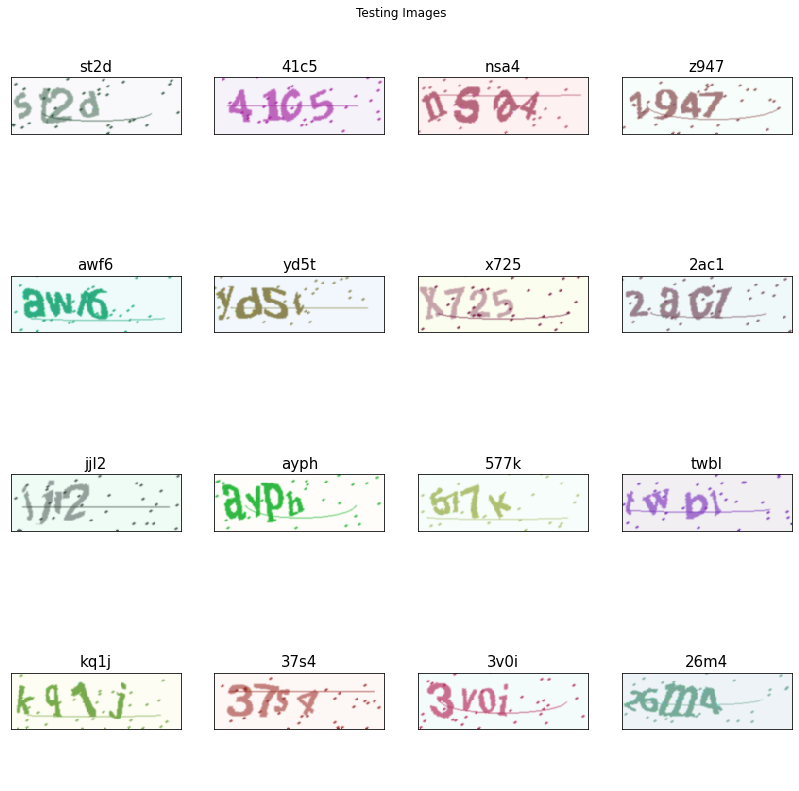

In [17]:
# view some test images
real_batch = next(iter(test_loader))
real_batch_pictures = np.transpose(real_batch[0].to(device).cpu().detach().numpy(),(0,2,3,1))
real_batch_pictures = UnNormalizeBatch(real_batch_pictures)

fig = plt.figure(figsize=(14,14))
plt.axis("off")
plt.title("Testing Images")

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(real_batch_pictures[i], interpolation='nearest')
    plt.title(real_batch[1][i], color='k', fontsize=15)

In [18]:
symbols_char = {k:v for k,v in enumerate(symbols, start=0)}
symbols_idx = {v:k for k,v in symbols_char.items()}
num_symbols = len(symbols_idx)

# Model

In [19]:
rnn_hidden_size = 256
resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [20]:
class CTC(nn.Module):
    
    def __init__(self, num_symbols, rnn_hidden_size=256, dropout=0.1):
        
        super(CTC, self).__init__()
        self.num_chars = num_symbols
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2 - for resnet18
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 256)

        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_symbols)
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        # print(batch.size())# torch.Size([-1, 256, 4, 10])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 10, 256, 4])
         
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 10, 1024])
        
        batch = self.linear1(batch)
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 512])
        
        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 20])
        
        batch = batch.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([10, -1, 20])
        
        return batch

In [21]:
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [22]:
ctc = CTC(num_symbols, rnn_hidden_size=rnn_hidden_size)
ctc.apply(weights_init)
ctc = ctc.to(device)
ctc

CTC(
  (cnn_p1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [23]:
image_batch, text_batch = iter(train_loader).next()
print(image_batch.size(), text_batch)

torch.Size([256, 3, 60, 180]) ('0b3y', 'nljc', 'dssu', 'ubei', '218v', 'opiq', 'l27b', 'aybr', 'e8rc', '2gft', 'g2ts', '3qka', '7mc5', '5zi8', 'cejj', 'e4fu', 'vtn5', '9kb4', '5avy', '3pl7', '9zuu', '5b3p', 'gqt0', '4k5c', '5tm4', '727x', 'jlni', '6aip', 'm1sy', '5ykc', 'xs14', 'zzlm', '5u3d', 'zx8l', 'ztb0', 'macv', 'm9zs', '9lgx', 'l7n3', '3wy3', 'pcnz', '7efa', 'yngh', 'mfmp', 'trgs', 'ux55', 'vj2l', '40pb', 'h7pf', '3tqd', '9zpr', 'm7lq', 'a8n3', 'yi1w', 'ohsw', 'syrv', '8jng', 'umyn', 'oau9', '1656', 'z5hf', 'sjai', 'ihdy', 'y8og', '8gu8', 'gjqg', 'hl64', 'dc3l', 'owoy', '4qq2', 'eucl', 'sk3p', '6gp6', 'gia7', '1gbn', '3km2', 'lr4t', 'yfdo', 'w7ix', 'qp19', 'o2e5', 'b5bh', '2m7z', 'dbow', 'kw0f', 'pjov', 'v6cw', 'ahp7', '0pde', 'oubc', '4x29', 'wv08', 'mmeu', 'cx9n', 'nr5r', 'mhf5', 'mero', '1vv1', 'julv', '5ikq', 'ko4i', 'q1tj', 'h9up', 'kssi', 'z9sl', 'pm3a', '0seh', 'vl2k', 'oyhj', 'jr2b', 'b3pg', 'qxxo', 'e2vk', '3tc7', '7p69', 'hmde', 'mhiu', 'd3g1', 'd4r0', '3ow6', 'vydk', '

In [24]:
text_batch_logits = ctc(image_batch.to(device))
print(text_batch)
print(text_batch_logits.shape)

('0b3y', 'nljc', 'dssu', 'ubei', '218v', 'opiq', 'l27b', 'aybr', 'e8rc', '2gft', 'g2ts', '3qka', '7mc5', '5zi8', 'cejj', 'e4fu', 'vtn5', '9kb4', '5avy', '3pl7', '9zuu', '5b3p', 'gqt0', '4k5c', '5tm4', '727x', 'jlni', '6aip', 'm1sy', '5ykc', 'xs14', 'zzlm', '5u3d', 'zx8l', 'ztb0', 'macv', 'm9zs', '9lgx', 'l7n3', '3wy3', 'pcnz', '7efa', 'yngh', 'mfmp', 'trgs', 'ux55', 'vj2l', '40pb', 'h7pf', '3tqd', '9zpr', 'm7lq', 'a8n3', 'yi1w', 'ohsw', 'syrv', '8jng', 'umyn', 'oau9', '1656', 'z5hf', 'sjai', 'ihdy', 'y8og', '8gu8', 'gjqg', 'hl64', 'dc3l', 'owoy', '4qq2', 'eucl', 'sk3p', '6gp6', 'gia7', '1gbn', '3km2', 'lr4t', 'yfdo', 'w7ix', 'qp19', 'o2e5', 'b5bh', '2m7z', 'dbow', 'kw0f', 'pjov', 'v6cw', 'ahp7', '0pde', 'oubc', '4x29', 'wv08', 'mmeu', 'cx9n', 'nr5r', 'mhf5', 'mero', '1vv1', 'julv', '5ikq', 'ko4i', 'q1tj', 'h9up', 'kssi', 'z9sl', 'pm3a', '0seh', 'vl2k', 'oyhj', 'jr2b', 'b3pg', 'qxxo', 'e2vk', '3tc7', '7p69', 'hmde', 'mhiu', 'd3g1', 'd4r0', '3ow6', 'vydk', 'fxc2', 'sscl', '63zu', 'am39',

In [25]:
criterion = nn.CTCLoss(blank=0)

In [26]:
def encode_text_batch(text_batch):
    
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = "".join(text_batch)
    text_batch_targets = [symbols_idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens

In [27]:
def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = torch.nn.functional.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) # [batch_size] 
    #print(text_batch_logps.shape)
    #print(text_batch_logps_lens) 
    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    #print(text_batch_targets)
    #print(text_batch_targets_lens)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

In [28]:
text_batch_logits.shape

torch.Size([9, 256, 62])

In [29]:
compute_loss(text_batch, text_batch_logits)

tensor(7.5587, device='cuda:0', grad_fn=<MeanBackward0>)

Train model

In [30]:
num_epochs = 8
lr = 0.001
weight_decay = 1e-3
clip_norm = 5

In [31]:
optimizer = optim.Adam(ctc.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5)

In [32]:
ctc = CTC(num_symbols, rnn_hidden_size=rnn_hidden_size)
ctc.apply(weights_init)
ctc = ctc.to(device)

In [33]:
epoch_losses = []
iteration_losses = []
num_updates_epochs = []

help_const = 0

for epoch in tqdm(range(1, num_epochs+1)):
    epoch_loss_list = [] 
    num_updates_epoch = 0
    for image_batch, text_batch in train_loader:
        optimizer.zero_grad()
        text_batch_logits = ctc(image_batch.to(device))
        loss = compute_loss(text_batch, text_batch_logits)
        iteration_loss = loss.item()

        if np.isnan(iteration_loss) or np.isinf(iteration_loss):
            continue
          
        num_updates_epoch += 1
        iteration_losses.append(iteration_loss)
        epoch_loss_list.append(iteration_loss)
        loss.backward()
        nn.utils.clip_grad_norm_(ctc.parameters(), clip_norm)
        optimizer.step()

        help_const = help_const + 1
        if (help_const % 100 == 0):
            print("Batch:{}    Loss:{}".format(help_const, np.mean(epoch_loss_list)))

    epoch_loss = np.mean(epoch_loss_list)
    print("Epoch:{}    Loss:{}    NumUpdates:{}".format(epoch, epoch_loss, num_updates_epoch))
    epoch_losses.append(epoch_loss)
    num_updates_epochs.append(num_updates_epoch)
    lr_scheduler.step(epoch_loss)

    help_const = 0

  0%|          | 0/8 [00:00<?, ?it/s]

Batch:100    Loss:4.249026639461517
Batch:200    Loss:3.7625808012485504
Batch:300    Loss:3.386475356419881
Batch:400    Loss:3.1451746875047686
Batch:500    Loss:2.9818607883453367
Batch:600    Loss:2.864342425664266
Batch:700    Loss:2.7740392228535242


 12%|█▎        | 1/8 [09:25<1:06:01, 565.87s/it]

Epoch:1    Loss:2.717761515956564    NumUpdates:776
Batch:100    Loss:2.1775633597373965
Batch:200    Loss:2.1663560426235198
Batch:300    Loss:2.1551835536956787
Batch:400    Loss:2.145328800678253
Batch:500    Loss:2.1371949768066405
Batch:600    Loss:2.1292398595809936
Batch:700    Loss:2.1227359526497978


 25%|██▌       | 2/8 [18:48<56:24, 564.14s/it]  

Epoch:2    Loss:2.117759634539024    NumUpdates:776
Batch:100    Loss:2.054873774051666
Batch:200    Loss:2.056342250108719
Batch:300    Loss:2.053159112930298
Batch:400    Loss:2.0488891780376433
Batch:500    Loss:2.046174714565277
Batch:600    Loss:2.0437711870670316
Batch:700    Loss:2.0399114881243023


 38%|███▊      | 3/8 [28:09<46:53, 562.62s/it]

Epoch:3    Loss:2.0376995503902435    NumUpdates:776
Batch:100    Loss:2.0045609140396117
Batch:200    Loss:2.0032486271858216
Batch:300    Loss:2.00265270113945
Batch:400    Loss:2.0004903733730317
Batch:500    Loss:1.9999833295345306
Batch:600    Loss:1.9972240030765533
Batch:700    Loss:1.9950209214006152


 50%|█████     | 4/8 [37:30<37:27, 561.88s/it]

Epoch:4    Loss:1.9934894969475638    NumUpdates:776
Batch:100    Loss:1.969439240694046
Batch:200    Loss:1.9717432636022567
Batch:300    Loss:1.9686692814032236
Batch:400    Loss:1.966565049290657
Batch:500    Loss:1.9662623534202575
Batch:600    Loss:1.9646019357442857
Batch:700    Loss:1.9626888818400248


 62%|██████▎   | 5/8 [46:50<28:04, 561.43s/it]

Epoch:5    Loss:1.961219513231946    NumUpdates:776
Batch:100    Loss:1.9490952467918397
Batch:200    Loss:1.9427422732114792
Batch:300    Loss:1.9414602438608806
Batch:400    Loss:1.942551716864109
Batch:500    Loss:1.942411985397339
Batch:600    Loss:1.941787949403127
Batch:700    Loss:1.9406199508053916


 75%|███████▌  | 6/8 [56:11<18:42, 561.17s/it]

Epoch:6    Loss:1.9395164097707296    NumUpdates:776
Batch:100    Loss:1.9348182141780854
Batch:200    Loss:1.9333915746212005
Batch:300    Loss:1.931706754763921
Batch:400    Loss:1.9303919342160225
Batch:500    Loss:1.929882546186447
Batch:600    Loss:1.9291881434122722
Batch:700    Loss:1.9285930253778185


 88%|████████▊ | 7/8 [1:05:31<09:20, 560.72s/it]

Epoch:7    Loss:1.9280250021784575    NumUpdates:776
Batch:100    Loss:1.923777425289154
Batch:200    Loss:1.921498452425003
Batch:300    Loss:1.9217624000708262
Batch:400    Loss:1.9217226362228395
Batch:500    Loss:1.9221029579639435
Batch:600    Loss:1.9224182389179865
Batch:700    Loss:1.9218994966575078


100%|██████████| 8/8 [1:14:50<00:00, 561.33s/it]

Epoch:8    Loss:1.9217314502013099    NumUpdates:776


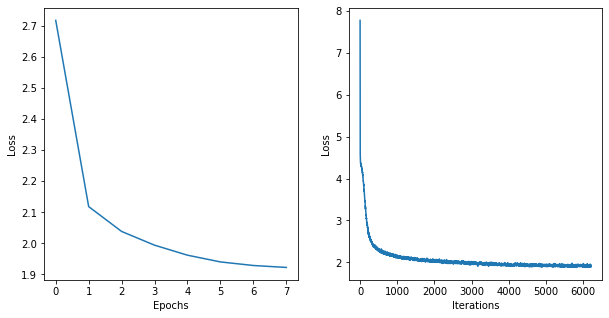

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epoch_losses)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(iteration_losses)
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")

plt.show()

# Predictions

In [35]:
def decode_predictions(text_batch_logits):

    text_batch_tokens = torch.nn.functional.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [symbols_char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [36]:
results_train = pd.DataFrame(columns=['actual', 'prediction'])
# train_loader = DataLoader(trainset, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(train_loader, leave=True):
        text_batch_logits = ctc(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_train = pd.concat([results_train, df])
results_train = results_train.reset_index(drop=True)

100%|██████████| 776/776 [04:22<00:00,  2.95it/s]


In [37]:
results_test = pd.DataFrame(columns=['actual', 'prediction'])
# test_loader = DataLoader(testset, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(test_loader, leave=True):
        text_batch_logits = ctc(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_test = pd.concat([results_test, df])
results_test = results_test.reset_index(drop=True)

100%|██████████| 157/157 [00:58<00:00,  2.68it/s]


In [38]:
print(results_train.shape)
results_train.head()

(198511, 2)


,actual,prediction
0,1vdc,1vddcAAAA
1,ivb8,ibb88AAAA
2,adrv,adrrvAAAA
3,7lf5,7lff5AAAA
4,2owe,2ooveeAAA


In [39]:
print(results_test.shape)
results_test.head()

(40000, 2)


,actual,prediction
0,st2d,st22dAAAA
1,41c5,41cc5AAAA
2,nsa4,nssa4AAAA
3,z947,z94477AAA
4,awf6,awwf6AAAA


In [51]:
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    corrected_word = corrected_word[0:4]
    return corrected_word

In [52]:
results_train['prediction_corrected'] = results_train['prediction'].apply(correct_prediction)
results_train.head()

,actual,prediction,prediction_corrected,ratcliff_obershelp
0,1vdc,1vddcAAAA,1vdc,0.888889
1,ivb8,ibb88AAAA,ib8A,0.888889
2,adrv,adrrvAAAA,adrv,0.888889
3,7lf5,7lff5AAAA,7lf5,0.888889
4,2owe,2ooveeAAA,2ove,0.888889


In [53]:
results_test['prediction_corrected'] = results_test['prediction'].apply(correct_prediction)
results_test.head()

,actual,prediction,prediction_corrected
0,st2d,st22dAAAA,st2d
1,41c5,41cc5AAAA,41c5
2,nsa4,nssa4AAAA,nsa4
3,z947,z94477AAA,z947
4,awf6,awwf6AAAA,awf6


Evaluate model

In [54]:
mistakes_df = results_test[results_test['actual'] != results_test['prediction_corrected']]
mistakes_df

,actual,prediction,prediction_corrected
8,jjl2,jjjjAAAAA,jA
10,577k,5777kAAAA,57kA
34,4hjm,4hhmmAAAA,4hmA
38,bi7c,b777cAAAA,b7cA
43,tini,tiiiiAAAA,tiA
...,...,...,...
39984,v5ii,v5iiiAAAA,v5iA
39986,wfot,wffftAAAA,wftA
39987,tcjq,tciiqAAAA,tciq
39991,p221,p222AAAAA,p2A


In [55]:
results_test

,actual,prediction,prediction_corrected
0,st2d,st22dAAAA,st2d
1,41c5,41cc5AAAA,41c5
2,nsa4,nssa4AAAA,nsa4
3,z947,z94477AAA,z947
4,awf6,awwf6AAAA,awf6
...,...,...,...
39995,2w9r,2w99rrAAA,2w9r
39996,6yj0,6yjj0AAAA,6yj0
39997,dn11,dhhhAAAAA,dhA
39998,9n2q,9n22qAAAA,9n2q


In [56]:
print(mistakes_df['prediction_corrected'].str.len().value_counts())

4    8202
3    1823
2     156
Name: prediction_corrected, dtype: int64


In [57]:
mask = mistakes_df['prediction_corrected'].str.len() == captcha_len
mistakes_df[mask]

,actual,prediction,prediction_corrected
10,577k,5777kAAAA,57kA
34,4hjm,4hhmmAAAA,4hmA
38,bi7c,b777cAAAA,b7cA
50,3ztn,3zttAAAAA,3ztA
52,bcje,bcieeAAAA,bcie
...,...,...,...
39966,qnlq,qnnqqAAAA,qnqA
39970,zsva,zssaaAAAA,zsaA
39984,v5ii,v5iiiAAAA,v5iA
39986,wfot,wffftAAAA,wftA


In [58]:
train_accuracy = accuracy_score(results_train['actual'], results_train['prediction_corrected'])
print('Train accuracy: ', train_accuracy)
test_accuracy = accuracy_score(results_test['actual'], results_test['prediction_corrected'])
print('Test accuracy: ', test_accuracy)

Train accuracy:  0.7507191037272494
Test accuracy:  0.745475


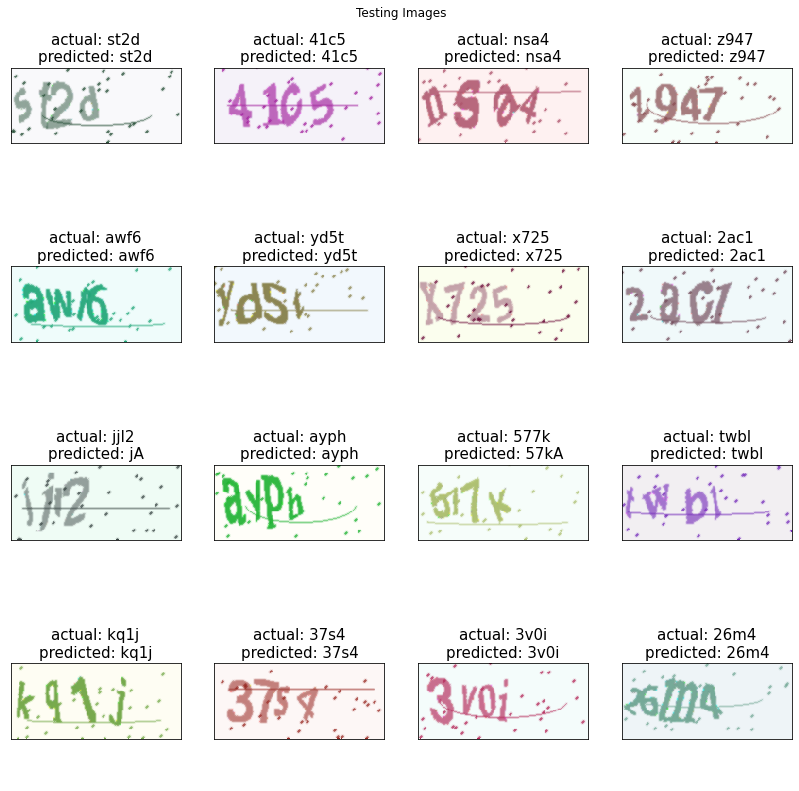

In [59]:
# view some test images and predictions

fig = plt.figure(figsize=(14,14))
plt.axis("off")
plt.title("Testing Images")

for i in range(16):
    result = results_test.iloc[i]
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    img = mpimg.imread('test/test/{}.png'.format(result[0]))
    ax.imshow(img, interpolation='nearest')
    plt.title('actual: ' + result[0] + '\n' + 'predicted: ' + result[2], color='k', fontsize=15)

In [60]:
! pip install textdistance

from textdistance import ratcliff_obershelp

In [61]:
for i in tqdm(range(len(results_train))):
    results_train['ratcliff_obershelp'] = ratcliff_obershelp(results_train.iloc[i,0], results_train.iloc[i,2])

100%|██████████| 198511/198511 [02:24<00:00, 1372.51it/s]


In [62]:
for i in tqdm(range(len(results_test))):
    results_test['ratcliff_obershelp'] = ratcliff_obershelp(results_test.iloc[i,0], results_test.iloc[i,2])

100%|██████████| 40000/40000 [00:28<00:00, 1404.33it/s]


In [63]:
print('Train Ratcliff-Obershelp: ', results_train['ratcliff_obershelp'].mean())
print('Test Ratcliff-Obershelp: ', results_test['ratcliff_obershelp'].mean())

Train Ratcliff-Obershelp:  1.0
Test Ratcliff-Obershelp:  1.0


In [65]:
PATH = "/content/drive/MyDrive/model_basic_resnet18_5_v1.pt"
torch.save(ctc.state_dict(), PATH)